# Online Fraud Transaction Detection
- By **Arshia Goshtasbi**
- Github: [@Arshiagosh](https://github.com/Arshiagosh)

**Description:**\
This Jupyter Notebook focuses on developing a decision tree algorithm to detect fraudulent online transactions. Fraudulent activities in virtual payments pose significant risks to financial institutions and security systems. Decision trees offer a powerful and interpretable method for classifying data based on feature attributes, making them well-suited for fraud detection tasks.

The notebook covers the end-to-end process of building a decision tree model, including data preprocessing, feature engineering, model training, and performance evaluation. Two popular criteria, `entropy` and `Gini index`, are used as splitting criteria for constructing the decision tree.

By exploring this notebook, readers can gain insights into the application of decision trees in fraud detection scenarios and understand the differences in performance between the entropy and Gini index as impurity measures.


## Importing libraries
In this section, the necessary libraries are imported, including `NumPy` for numerical computations, `Pandas` for data manipulation, `Seaborn` and `Matplotlib` for data visualization, and `Scikit-learn` for evaluation metrics. Additionally, a custom implementation of the Decision Tree algorithm is imported from the `DT` module.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from DT import DecisionTree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

## Data Loading
The dataset containing online transaction records is loaded from a `CSV` file using Pandas. The `df.info()` function provides an overview of the dataset, including the number of rows and columns, data types, and non-null values.

In [2]:
# Importing the dataset
df=pd.read_csv('onlinefraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 7.6+ MB


## Data Cleaning
Data cleaning is a crucial step in any data science project. In this section, the following steps are performed:

1) The number of null values in each column is calculated using `df.isnull().sum()`.
2) Rows with null values are removed using `df.dropna()`.
3) Duplicate rows are removed using `df.drop_duplicates()`.
4) The columns `nameOrig` and `nameDest` are dropped as they are deemed not useful for the analysis.
5) A quick overview of the cleaned dataset is displayed using `df.head()`.

In [3]:
# Finding howmany Nulls are there.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [4]:
# Removing any NaN
df = df.dropna()
# Removing any Duplicates
df = df.drop_duplicates()
# Counting the null values in each attribute
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

The data was clean already so that's awesome to know!

In [5]:
# Dropping useless info
df.drop(columns=['nameOrig','nameDest'],inplace=True)

In [6]:
# A simple overview
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


## Preprocessing Tools
This section introduces several preprocessing techniques used in the notebook, including one-hot encoding and binning.

### One-Hot Encoding for `type` Column
One-hot encoding is a technique used to convert categorical data into a format suitable for machine learning algorithms. It creates binary columns for each category, where a value of `1` indicates the presence of that category, and `0` indicates its absence.

In [7]:
# Define a function for one-hot encoding
def one_hot_encode(df):
    df_new = df.copy()
    # Get the 'type' column
    types = df_new['type']
    # Get unique types
    unique_types = sorted(set(types))
    # Create one-hot encoded columns
    for t in unique_types:
        df_new[t] = (types == t).astype(int)
    # Drop the original 'type' column
    df_new.drop('type', axis=1, inplace=True)
    return df_new

The `one_hot_encode` function takes a DataFrame as input and performs one-hot encoding on the `type` column. It creates new binary columns for each unique value in the `type` column and drops the original `type` column.

### Binning
Binning is a technique used to discretize continuous features or features with a large range of numerical values. It divides the range of values into equal-width intervals (bins) and assigns each value to its corresponding bin.

In [24]:
def equal_width_binning(df, n_bins=100, column_to_ignore=None):
  """
  Bins each column in the DataFrame using equal-width intervals, excluding the specified column.

  Parameters:
    df: pandas DataFrame
      Input DataFrame to be binned.
    n_bins: int, optional (default=100)
      Number of bins to create for each column.
    column_to_ignore: str or list of str, optional
      Column(s) to exclude from binning.

  Returns:
    df_binned: pandas DataFrame       with each column (except the ignored one) binned using equal-width intervals.
  """

  # Handle potential None value for column_to_ignore
  if column_to_ignore is None:
    column_to_ignore = []

  # Iterate through columns excluding the ones to ignore
  for column in df.columns:
    if column not in column_to_ignore:
      min_val = df[column].min()
      max_val = df[column].max()
      width = (max_val - min_val) / n_bins
      bins = [min_val + i * width for i in range(n_bins + 1)]
      df[column] = pd.cut(df[column], bins=bins, labels=False, include_lowest=True, duplicates='drop')

  return df

The `equal_width_binning` function takes a `DataFrame`, the number of bins `(n_bins)`, and an optional list of columns to ignore `(column_to_ignore)` as input. It bins each column (except the ignored ones) using equal-width intervals, dividing the range of values into `n_bins` bins. The binned values are then replaced in the original DataFrame.

### Separating dataset based on `type`
The `seperate_on_type` function takes a `DataFrame` and a specific `type` value as input. It creates a new `DataFrame` containing only the rows where the `type` column matches the specified value. Additionally, it drops the `type` column from the resulting DataFrame.

In [9]:
def seperate_on_type(df, type_search):
    df_new = df.loc[(df.type==type_search)]
    df_new = df_new.drop(columns=['type'])
    return df_new

### Splitting the dataset into training and test
The split_data function is responsible for splitting the dataset into training and testing sets while maintaining a balanced distribution of fraud and non-fraud classes. It takes three arguments:

1) `data`: The input DataFrame containing the data.
2) `test_size` (default: 0.5): The proportion of data to be included in the test set.
3) `pos_ratio` (default: 0.5): The desired proportion of positive (fraud) cases in each set. \

The function first separates the data into fraud and non-fraud instances. It then calculates the sizes of the training and testing sets based on the `test_size` parameter, ensuring integer split sizes to avoid sampling errors. Next, it samples with replacement from the fraud and non-fraud instances to create balanced subsets with the desired `pos_ratio` of positive cases in each set.

Finally, the function separates the features `(X_train, X_test)` and labels `(y_train, y_test)` and returns them as a tuple.

In [10]:
def split_data(data, test_size=0.5, pos_ratio=0.5):
  """Splits data into training and testing sets with balanced fraud classes and configurable ratios.

  Args:
    data: A pandas DataFrame containing the data.
    test_size: The proportion of data to be included in the test set (default: 0.5).
    pos_ratio: The desired proportion of positive (True) class in each set (default: 0.5).

  Returns:
    A tuple containing four elements: X_train, X_test, y_train, y_test.
  """

  fraud_data = data[data['isFraud'] == True]
  non_fraud_data = data[data['isFraud'] == False]

  # Ensure data allows for desired positive ratio
  min_class_size = min(len(fraud_data), len(non_fraud_data))
  min_positive_size = int(min_class_size * pos_ratio)
  if min_positive_size > min(len(fraud_data), len(non_fraud_data)):
    raise ValueError("Data has insufficient positive class to achieve desired ratio")

  # Calculate split sizes based on test_size and desired positive ratio
  total_size = len(data)
  test_size_adjusted = test_size * total_size
  train_size = total_size - test_size_adjusted

  # Ensure integer split sizes to avoid sampling errors
  positive_train_size = int(train_size * pos_ratio)
  negative_train_size = int(train_size - positive_train_size)

  positive_test_size = int(test_size_adjusted * pos_ratio)
  negative_test_size = int(test_size_adjusted - positive_test_size)

  # Sample with replacement to achieve balanced subsets
  fraud_train = fraud_data.sample(positive_train_size, replace=True)
  if negative_train_size > 0:
      non_fraud_train = non_fraud_data.sample(negative_train_size, replace=True)
  else:
      non_fraud_train = pd.DataFrame()

  fraud_test = fraud_data.sample(positive_test_size, replace=True)
  if negative_test_size > 0:
      non_fraud_test = non_fraud_data.sample(negative_test_size, replace=True)
  else:
      non_fraud_test = pd.DataFrame()

  # Separate features (X) and labels (y)
  X_train = pd.concat([fraud_train.drop('isFraud', axis=1), non_fraud_train.drop('isFraud', axis=1)])
  y_train = pd.concat([fraud_train['isFraud'], non_fraud_train['isFraud']])

  X_test = pd.concat([fraud_test.drop('isFraud', axis=1), non_fraud_test.drop('isFraud', axis=1)])
  y_test = pd.concat([fraud_test['isFraud'], non_fraud_test['isFraud']])

  return X_train, X_test, y_train, y_test

## Evaluation Tools
This section introduces two functions for evaluating the performance of the trained models: `print_corr` for visualizing the correlation matrix, and `print_eval` for computing and visualizing various evaluation metrics.

### Correlation Matrix
The `print_corr` function takes a `DataFrame` as input and computes the correlation matrix using `df.corr()`. It then creates a heatmap visualization of the correlation matrix using Seaborn's `sns.heatmap`. The heatmap displays the correlation values with annotations, using a diverging colormap ('coolwarm') and a specific format (fmt=".2f") for the annotations.

In [11]:
def print_corr(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

### Confusion Matrix and Metrics
The print_eval function is used to evaluate the performance of a binary classification model. It takes two arguments:

1) `y_pred`: The predicted labels from the model.
2) `y_test`: The true labels from the test set.
The function first computes the confusion matrix using `confusion_matrix(y_test, y_pred)` from Scikit-learn. It then visualizes the confusion matrix using Matplotlib's `plt.imshow`, with annotations for the individual values and a colorbar.

Additionally, the function calculates several evaluation metrics:

* `Accuracy`: The overall accuracy of the model's predictions.
* `Precision`: The ratio of true positives to the sum of true positives and false positives.
* `Recall`: The ratio of true positives to the sum of true positives and false negatives.
* `F1-Score`: The harmonic mean of precision and recall, providing a balanced measure of the model's performance.

These metrics are computed using functions from Scikit-learn and printed to the console.

In [12]:
def print_eval(y_pred, y_test):
    # Assuming y_test and y_pred are your test labels and predicted labels, respectively
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

    # Calculate additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

## Modeling
This section presents three different modeling approaches for fraud detection using the decision tree algorithm.

#### Approach 1
In this approach:
1) The first 2000 rows of the data are used to train the dataset, and the next 2000 rows are used for testing.
2) No other preprocessing is done.

In [ ]:
df_ap1 = df.copy()

# Splitting the data for training and testing
X_train = df_ap1.drop(columns=['isFraud']).iloc[:2000]
y_train = df_ap1['isFraud'].iloc[:2000]

X_test = df_ap1.drop(columns=['isFraud']).iloc[2000:4000]
y_test = df_ap1['isFraud'].iloc[2000:4000]

##### Entropy

In [ ]:
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
print_eval(y_pred, y_test)

##### Gini Index

In [ ]:
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
print_eval(y_pred, y_test)

##### Result
This approach takes a significant amount of time, and as seen in the metrics, the model is saturated to 0 and underfits. Some preprocessing methods should be used to improve the model's performance.

### Approach 2
In this approach:
1) One Hot Encoding is used for the `type` feature to convert the categorical variable into a numerical format.
2) Binning is used to transform the continuous features into bins (1000 bins).
3) The dataset is split using the split_data function, with two parameters `(test_size, pos_ratio)`:
    * `test_size`: The test size ratio.
    * `pos_ratio`: The ratio of positive (fraud) samples in both the test set and training set.

In [13]:
df_oneHot = one_hot_encode(df)
df_oneHot = equal_width_binning(df_oneHot, n_bins=1000,
                                column_to_ignore=['isFraud','CASH_IN',
                                                  'CASH_OUT','DEBIT',
                                                  'PAYMENT','TRANSFER'])

In [14]:
df_oneHot.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,5,4,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,1,0


In [15]:
X_train, X_test, y_train, y_test = split_data(df_oneHot, test_size=0.25, pos_ratio=0.25)

##### Entropy

X_2 ? 0.43449505800362687
├─ Value = 0.0
│  X_1 ? 0.569322525381032
│  ├─ Value = 0.0
│  │  0.0
│  ├─ Value = 1.0
│  │  0.0
│  ├─ Value = 2.0
│  │  0.0
│  ├─ Value = 3.0
│  │  X_0 ? 0.8812908992306927
│  │  ├─ Value = 111.0
│  │  │  0.0
│  │  ├─ Value = 333.0
│  │  │  1.0
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  └─ 
│  ├─ Value = 4.0
│  │  0.0
│  ├─ Value = 5.0
│  │  0.0
│  ├─ Value = 6.0
│  │  0.0
│  ├─ Value = 7.0
│  │  0.0
│  ├─ Value = 8.0
│  │  0.0
│  ├─ Value = 9.0
│  │  0.0
│  ├─ Value = 10.0
│  │  0.0
│  ├─ Value = 11.0
│  │  0.0
│  ├─ Value = 12.0
│  │  0.0
│  ├─ Value = 13.0
│  │  0.0
│  ├─ Value = 14.0
│  │  0.0
│  ├─ Value = 15.0
│  │  0.0
│  ├─ Value = 16.0
│  │  0.0
│  ├─ Value = 17.0
│  │  0.0
│  ├─ Value = 18.0
│  │  0.0
│  ├─ Value = 19.0
│  │  X_0 ? 0.6500224216483541
│  │  ├─ Value = 666.0
│  │  │  0.0
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  ├─ Value = 999.0
│  │  │  1.0
│  │  └─ 
│  ├─ Value = 20.0
│  │  0.0
│  ├─ Value = 21.0
│  │  0.0
│  ├─ Value = 23.0
│  │  0

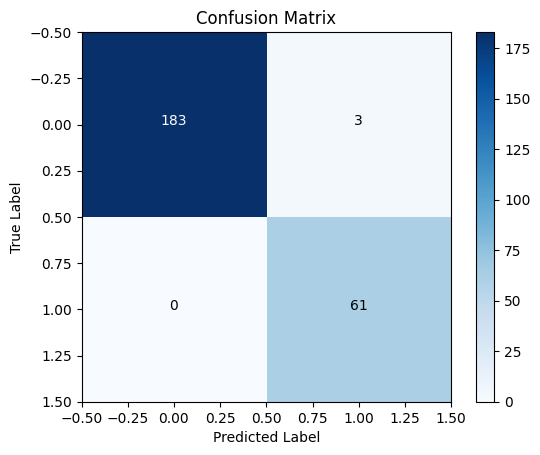

Accuracy: 0.9879
Precision: 0.9531
Recall: 1.0000
F1-Score: 0.9760


In [25]:
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

##### Gini Index

X_2 ? 0.20486127726615636
├─ Value = 0.0
│  X_1 ? 0.2449777777777779
│  ├─ Value = 0.0
│  │  0.0
│  ├─ Value = 1.0
│  │  0.0
│  ├─ Value = 2.0
│  │  0.0
│  ├─ Value = 3.0
│  │  X_0 ? 0.42000000000000004
│  │  ├─ Value = 111.0
│  │  │  0.0
│  │  ├─ Value = 333.0
│  │  │  1.0
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  └─ 
│  ├─ Value = 4.0
│  │  0.0
│  ├─ Value = 5.0
│  │  0.0
│  ├─ Value = 6.0
│  │  0.0
│  ├─ Value = 7.0
│  │  0.0
│  ├─ Value = 8.0
│  │  0.0
│  ├─ Value = 9.0
│  │  0.0
│  ├─ Value = 10.0
│  │  0.0
│  ├─ Value = 11.0
│  │  0.0
│  ├─ Value = 12.0
│  │  0.0
│  ├─ Value = 13.0
│  │  0.0
│  ├─ Value = 14.0
│  │  0.0
│  ├─ Value = 15.0
│  │  0.0
│  ├─ Value = 16.0
│  │  0.0
│  ├─ Value = 17.0
│  │  0.0
│  ├─ Value = 18.0
│  │  0.0
│  ├─ Value = 19.0
│  │  X_0 ? 0.2777777777777777
│  │  ├─ Value = 666.0
│  │  │  0.0
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  ├─ Value = 999.0
│  │  │  1.0
│  │  └─ 
│  ├─ Value = 20.0
│  │  0.0
│  ├─ Value = 21.0
│  │  0.0
│  ├─ Value = 23.0
│  │ 

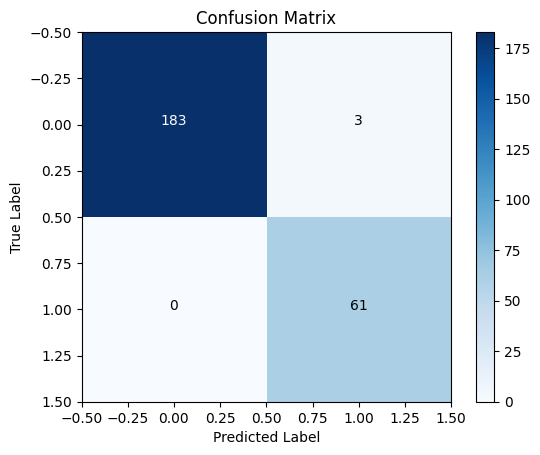

Accuracy: 0.9879
Precision: 0.9531
Recall: 1.0000
F1-Score: 0.9760


In [26]:
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

#### Result
The use of One Hot Encoding and Binning techniques improved the model's performance compared to the previous approach.

### Approach 3
In this approach:
1) Each `type` of transaction is separated into its own dataset.
2) Binning is used to transform the continuous features into bins (1000 bins).
3) The dataset is split using the `split_data` function, with two parameters (`test_size`, `pos_ratio`):
   * `test_size`: The test size ratio.
   * `pos_ratio`: The ratio of positive (fraud) samples in both the test set and training set.


##### Entropy

X_5 ? 0.215739001773262
├─ Value = 0
│  X_1 ? 0.389231257063151
│  ├─ Value = 0
│  │  X_4 ? 0.17898422916934742
│  │  ├─ Value = 0
│  │  │  X_2 ? 0.17358619667353425
│  │  │  ├─ Value = 0
│  │  │  │  X_0 ? 0.1446448461909765
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 444
│  │  │  │  │  1
│  │  │  │  ├─ Value = 555
│  │  │  │  │  0
│  │  │  │  ├─ Value = 666
│  │  │  │  │  1
│  │  │  │  ├─ Value = 777
│  │  │  │  │  1
│  │  │  │  ├─ Value = 888
│  │  │  │  │  1
│  │  │  │  └─ 
│  │  │  ├─ Value = 3
│  │  │  │  1
│  │  │  ├─ Value = 5
│  │  │  │  0
│  │  │  ├─ Value = 6
│  │  │  │  1
│  │  │  ├─ Value = 42
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 1
│  │  │  0
│  │  ├─ Value = 3
│  │  │  0
│  │  ├─ Value = 5
│  │  │  1
│  │  └─ 
│  ├─ Value = 1
│  │  X_0 ? 0.32587648960030835
│  │  ├─ Value = 0
│  │  │  X_2 ? 0.863120568566631
│  │  │  ├─ Value = 0
│  │  │  │  0
│  │  │  ├─ Value = 1
│  │  │  │  1
│  │  │  ├─ Value = 6
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 1

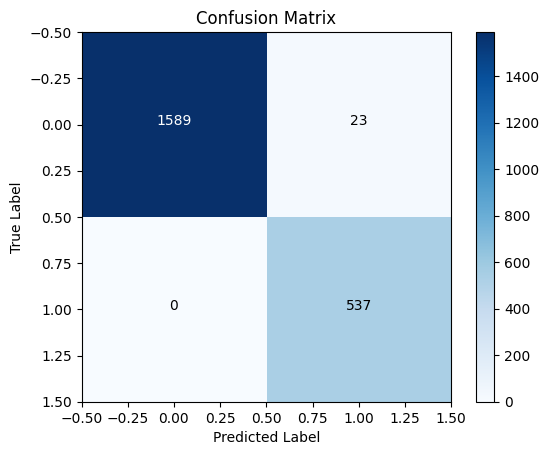

Accuracy: 0.9893
Precision: 0.9589
Recall: 1.0000
F1-Score: 0.9790


In [27]:
df_transfer = seperate_on_type(df, 'TRANSFER')
df_transfer = equal_width_binning(df_transfer, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_transfer, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.17330703157191008
├─ Value = 0
│  X_2 ? 0.5793510805766127
│  ├─ Value = 0
│  │  X_5 ? 0.5554201571282549
│  │  ├─ Value = 0
│  │  │  1
│  │  ├─ Value = 2
│  │  │  0
│  │  ├─ Value = 4
│  │  │  0
│  │  ├─ Value = 6
│  │  │  X_4 ? 0.4689955935892812
│  │  │  ├─ Value = 1
│  │  │  │  0
│  │  │  ├─ Value = 12
│  │  │  │  1
│  │  │  └─ 
│  │  ├─ Value = 9
│  │  │  0
│  │  ├─ Value = 22
│  │  │  0
│  │  └─ 
│  ├─ Value = 1
│  │  0
│  ├─ Value = 2
│  │  0
│  ├─ Value = 4
│  │  0
│  ├─ Value = 13
│  │  0
│  ├─ Value = 38
│  │  0
│  ├─ Value = 44
│  │  0
│  ├─ Value = 46
│  │  0
│  ├─ Value = 47
│  │  0
│  ├─ Value = 50
│  │  1
│  ├─ Value = 60
│  │  0
│  ├─ Value = 72
│  │  0
│  ├─ Value = 74
│  │  0
│  ├─ Value = 84
│  │  0
│  ├─ Value = 99
│  │  0
│  ├─ Value = 111
│  │  0
│  ├─ Value = 114
│  │  0
│  ├─ Value = 115
│  │  0
│  ├─ Value = 117
│  │  0
│  ├─ Value = 118
│  │  0
│  ├─ Value = 123
│  │  0
│  ├─ Value = 125
│  │  0
│  ├─ Value = 160
│  │  0
│  ├─ Value = 183
│  │  0
│  ├─

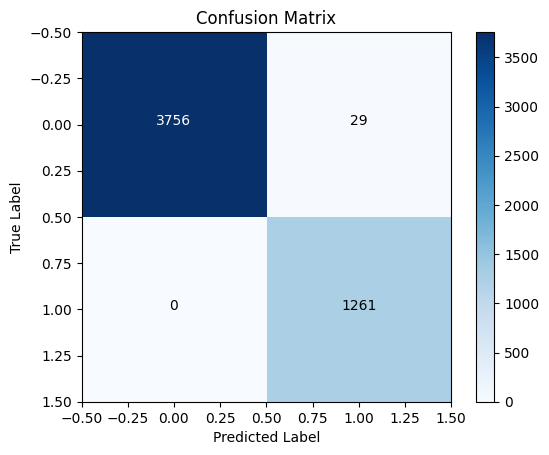

Accuracy: 0.9943
Precision: 0.9775
Recall: 1.0000
F1-Score: 0.9886


In [28]:
df_cash_in = seperate_on_type(df, 'CASH_IN')
df_cash_in = equal_width_binning(df_cash_in, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_cash_in, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_5 ? 0.08017646589706018
├─ Value = 0
│  X_1 ? 0.14486503519082872
│  ├─ Value = 0
│  │  X_3 ? 0.1413774005769105
│  │  ├─ Value = 0
│  │  │  X_0 ? 0.24733138225961082
│  │  │  ├─ Value = 0
│  │  │  │  X_4 ? 0.08408871692056041
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 3
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 222
│  │  │  │  0
│  │  │  ├─ Value = 333
│  │  │  │  0
│  │  │  ├─ Value = 666
│  │  │  │  X_4 ? 0.40076314263583634
│  │  │  │  ├─ Value = 0
│  │  │  │  │  X_2 ? 0.13701850183231923
│  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  1
│  │  │  │  │  ├─ Value = 1
│  │  │  │  │  │  0
│  │  │  │  │  └─ 
│  │  │  │  ├─ Value = 1
│  │  │  │  │  0
│  │  │  │  ├─ Value = 2
│  │  │  │  │  0
│  │  │  │  ├─ Value = 9
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 777
│  │  │  │  X_2 ? 0.16050543100361614
│  │  │  │  ├─ Value = 0
│  │  │  │  │  X_4 ? 0.04914140669335687
│  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  1
│  │  │  │  │  ├─ Value = 2
│  │  

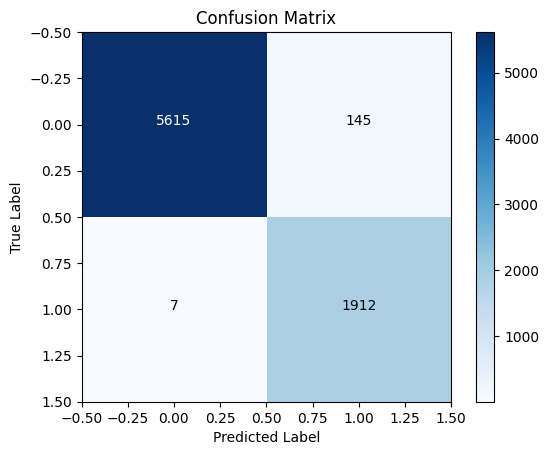

Accuracy: 0.9802
Precision: 0.9295
Recall: 0.9964
F1-Score: 0.9618


In [29]:
df_cash_out = seperate_on_type(df, 'CASH_OUT')
df_cash_out = equal_width_binning(df_cash_out, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_cash_out, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.09388074995039575
├─ Value = 0.0
│  X_0 ? 0.5211164641800623
│  ├─ Value = 0.0
│  │  0.0
│  ├─ Value = 222.0
│  │  0.0
│  ├─ Value = 333.0
│  │  0.0
│  ├─ Value = 444.0
│  │  0.0
│  ├─ Value = 555.0
│  │  0.0
│  ├─ Value = 666.0
│  │  X_2 ? 0.30267158418388973
│  │  ├─ Value = 0.0
│  │  │  1.0
│  │  ├─ Value = 1.0
│  │  │  0.0
│  │  ├─ Value = 2.0
│  │  │  1.0
│  │  ├─ Value = 4.0
│  │  │  0.0
│  │  ├─ Value = 9.0
│  │  │  0.0
│  │  ├─ Value = 507.0
│  │  │  1.0
│  │  └─ 
│  ├─ Value = 777.0
│  │  0.0
│  ├─ Value = 888.0
│  │  0.0
│  ├─ Value = 999.0
│  │  0.0
│  └─ 
├─ Value = 1.0
│  X_2 ? 0.3805456825394884
│  ├─ Value = 0.0
│  │  X_0 ? 0.4731190341192222
│  │  ├─ Value = 0.0
│  │  │  0.0
│  │  ├─ Value = 111.0
│  │  │  0.0
│  │  ├─ Value = 222.0
│  │  │  0.0
│  │  ├─ Value = 444.0
│  │  │  0.0
│  │  ├─ Value = 555.0
│  │  │  0.0
│  │  ├─ Value = 666.0
│  │  │  1.0
│  │  ├─ Value = 777.0
│  │  │  1.0
│  │  ├─ Value = 888.0
│  │  │  0.0
│  │  ├─ Value = 999.0
│  │  │  0.0
│  │

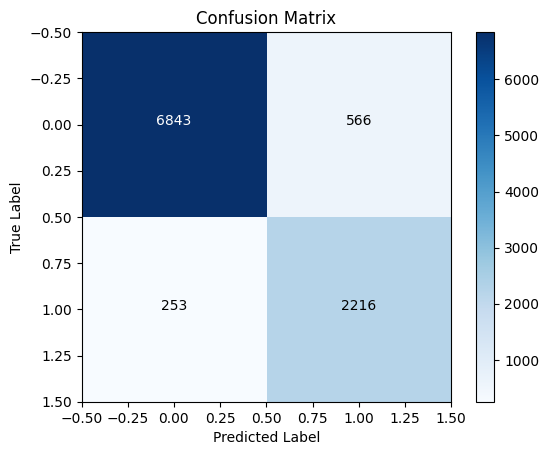

Accuracy: 0.9171
Precision: 0.7965
Recall: 0.8975
F1-Score: 0.8440


In [30]:
df_payment = seperate_on_type(df, 'PAYMENT')
df_payment = equal_width_binning(df_payment, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_payment, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_3 ? 0.3986117826454248
├─ Value = 0.0
│  X_1 ? 0.5953839119182545
│  ├─ Value = 0.0
│  │  0.0
│  ├─ Value = 1.0
│  │  0.0
│  ├─ Value = 2.0
│  │  0.0
│  ├─ Value = 3.0
│  │  1.0
│  ├─ Value = 4.0
│  │  0.0
│  ├─ Value = 6.0
│  │  0.0
│  ├─ Value = 7.0
│  │  0.0
│  ├─ Value = 8.0
│  │  0.0
│  ├─ Value = 9.0
│  │  0.0
│  ├─ Value = 10.0
│  │  0.0
│  ├─ Value = 12.0
│  │  0.0
│  ├─ Value = 13.0
│  │  0.0
│  ├─ Value = 16.0
│  │  0.0
│  ├─ Value = 17.0
│  │  0.0
│  ├─ Value = 18.0
│  │  0.0
│  ├─ Value = 19.0
│  │  X_0 ? 0.74959525725948
│  │  ├─ Value = 666.0
│  │  │  0.0
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  ├─ Value = 999.0
│  │  │  1.0
│  │  └─ 
│  ├─ Value = 20.0
│  │  0.0
│  ├─ Value = 21.0
│  │  0.0
│  ├─ Value = 22.0
│  │  0.0
│  ├─ Value = 23.0
│  │  0.0
│  ├─ Value = 24.0
│  │  0.0
│  ├─ Value = 25.0
│  │  0.0
│  ├─ Value = 26.0
│  │  0.0
│  ├─ Value = 27.0
│  │  0.0
│  ├─ Value = 29.0
│  │  0.0
│  ├─ Value = 30.0
│  │  0.0
│  ├─ Value = 32.0
│  │  0.0
│  ├─ Value = 33.0
│ 

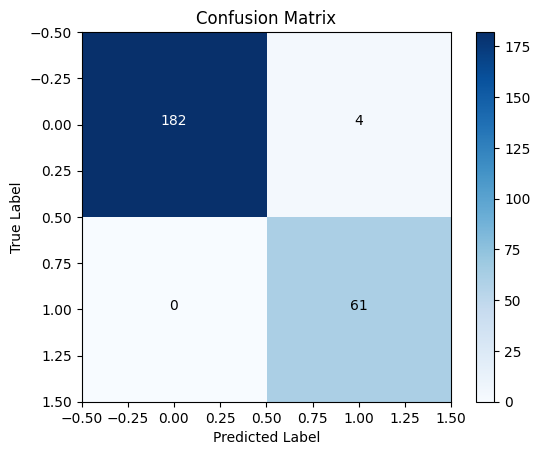

Accuracy: 0.9838
Precision: 0.9385
Recall: 1.0000
F1-Score: 0.9683


In [31]:
df_debit = seperate_on_type(df, 'DEBIT')
df_debit = equal_width_binning(df_debit, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_debit, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='entropy')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]

print_eval(y_pred, y_test)

##### Gini Index

X_5 ? 0.08637898455090792
├─ Value = 0
│  X_1 ? 0.21579574271491558
│  ├─ Value = 0
│  │  X_2 ? 0.10119750379490633
│  │  ├─ Value = 0
│  │  │  X_0 ? 0.1481427663245845
│  │  │  ├─ Value = 0
│  │  │  │  1
│  │  │  ├─ Value = 444
│  │  │  │  1
│  │  │  ├─ Value = 555
│  │  │  │  0
│  │  │  ├─ Value = 666
│  │  │  │  1
│  │  │  ├─ Value = 777
│  │  │  │  1
│  │  │  ├─ Value = 888
│  │  │  │  X_4 ? 0.10884353741496611
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 1
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 999
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 1
│  │  │  0
│  │  ├─ Value = 2
│  │  │  0
│  │  ├─ Value = 3
│  │  │  1
│  │  ├─ Value = 5
│  │  │  0
│  │  ├─ Value = 6
│  │  │  1
│  │  ├─ Value = 42
│  │  │  0
│  │  ├─ Value = 106
│  │  │  1
│  │  └─ 
│  ├─ Value = 1
│  │  X_0 ? 0.1524130399542239
│  │  ├─ Value = 0
│  │  │  X_2 ? 0.3046875
│  │  │  ├─ Value = 0
│  │  │  │  0
│  │  │  ├─ Value = 1
│  │  │  │  1
│  │  │  └─ 
│  │  ├─ Value = 111
│  │  │  1

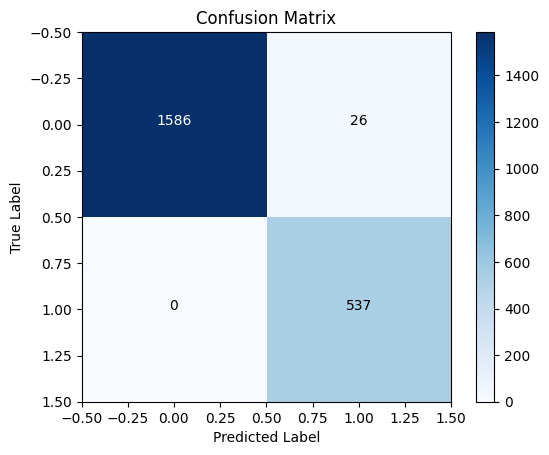

Accuracy: 0.9879
Precision: 0.9538
Recall: 1.0000
F1-Score: 0.9764


In [32]:
df_transfer = seperate_on_type(df, 'TRANSFER')
df_transfer = equal_width_binning(df_transfer, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_transfer, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.07018657952857676
├─ Value = 0
│  X_2 ? 0.3549792698144346
│  ├─ Value = 0
│  │  X_4 ? 0.20023148148148154
│  │  ├─ Value = 0
│  │  │  X_0 ? 0.15123456790123457
│  │  │  ├─ Value = 777
│  │  │  │  X_5 ? 0.21875
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 2
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 888
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 1
│  │  │  0
│  │  ├─ Value = 12
│  │  │  1
│  │  ├─ Value = 25
│  │  │  0
│  │  └─ 
│  ├─ Value = 1
│  │  0
│  ├─ Value = 2
│  │  0
│  ├─ Value = 5
│  │  0
│  ├─ Value = 6
│  │  0
│  ├─ Value = 10
│  │  0
│  ├─ Value = 13
│  │  0
│  ├─ Value = 20
│  │  0
│  ├─ Value = 22
│  │  0
│  ├─ Value = 39
│  │  0
│  ├─ Value = 41
│  │  0
│  ├─ Value = 44
│  │  0
│  ├─ Value = 50
│  │  1
│  ├─ Value = 74
│  │  0
│  ├─ Value = 84
│  │  0
│  ├─ Value = 85
│  │  0
│  ├─ Value = 101
│  │  0
│  ├─ Value = 117
│  │  0
│  ├─ Value = 118
│  │  0
│  ├─ Value = 160
│  │  0
│  ├─ Value = 169
│  │  0
│  ├─ Value = 183
│  │  0
│

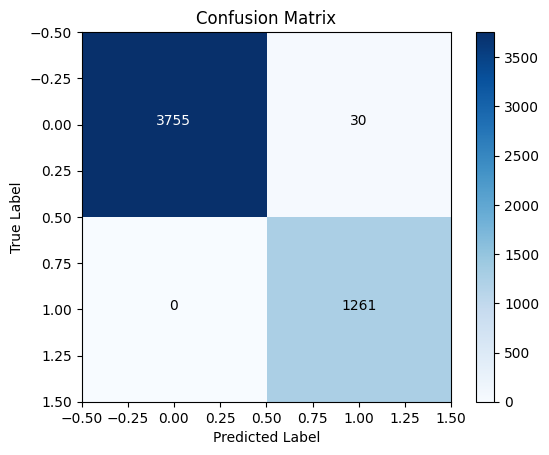

Accuracy: 0.9941
Precision: 0.9768
Recall: 1.0000
F1-Score: 0.9882


In [33]:
df_cash_in = seperate_on_type(df, 'CASH_IN')
df_cash_in = equal_width_binning(df_cash_in, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_cash_in, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_5 ? 0.03408488856942449
├─ Value = 0
│  X_1 ? 0.05248864618908072
│  ├─ Value = 0
│  │  X_2 ? 0.07609825639228385
│  │  ├─ Value = 0
│  │  │  X_0 ? 0.11606407368913119
│  │  │  ├─ Value = 0
│  │  │  │  X_4 ? 0.07768529528339269
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 3
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 222
│  │  │  │  0
│  │  │  ├─ Value = 333
│  │  │  │  0
│  │  │  ├─ Value = 555
│  │  │  │  0
│  │  │  ├─ Value = 666
│  │  │  │  X_4 ? 0.1799816345270891
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 2
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 777
│  │  │  │  X_4 ? 0.11690335638387594
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 1
│  │  │  │  │  0
│  │  │  │  ├─ Value = 3
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 888
│  │  │  │  X_4 ? 0.08122680890538031
│  │  │  │  ├─ Value = 0
│  │  │  │  │  0
│  │  │  │  ├─ Value = 1
│  │  │  │  │  0
│  │  │  │  ├─ Value = 2
│  │  │  │  │  1
│  

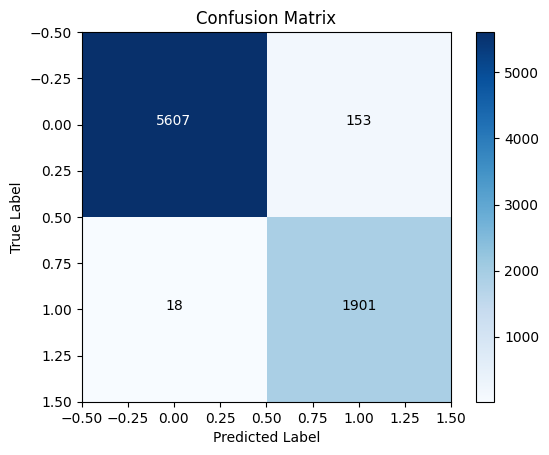

Accuracy: 0.9777
Precision: 0.9255
Recall: 0.9906
F1-Score: 0.9570


In [34]:
df_cash_out = seperate_on_type(df, 'CASH_OUT')
df_cash_out = equal_width_binning(df_cash_out, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_cash_out, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.04176604514325366
├─ Value = 0.0
│  X_0 ? 0.24228156887755092
│  ├─ Value = 0.0
│  │  0.0
│  ├─ Value = 111.0
│  │  0.0
│  ├─ Value = 333.0
│  │  0.0
│  ├─ Value = 444.0
│  │  0.0
│  ├─ Value = 555.0
│  │  0.0
│  ├─ Value = 666.0
│  │  X_2 ? 0.13939965205885105
│  │  ├─ Value = 0.0
│  │  │  1.0
│  │  ├─ Value = 2.0
│  │  │  1.0
│  │  ├─ Value = 44.0
│  │  │  0.0
│  │  ├─ Value = 507.0
│  │  │  1.0
│  │  └─ 
│  ├─ Value = 777.0
│  │  0.0
│  ├─ Value = 888.0
│  │  0.0
│  ├─ Value = 999.0
│  │  0.0
│  └─ 
├─ Value = 1.0
│  X_2 ? 0.22694830246913583
│  ├─ Value = 0.0
│  │  X_0 ? 0.2826466049382716
│  │  ├─ Value = 0.0
│  │  │  0.0
│  │  ├─ Value = 111.0
│  │  │  0.0
│  │  ├─ Value = 333.0
│  │  │  0.0
│  │  ├─ Value = 444.0
│  │  │  0.0
│  │  ├─ Value = 666.0
│  │  │  1.0
│  │  ├─ Value = 777.0
│  │  │  1.0
│  │  ├─ Value = 888.0
│  │  │  0.0
│  │  ├─ Value = 999.0
│  │  │  0.0
│  │  └─ 
│  ├─ Value = 1.0
│  │  0.0
│  ├─ Value = 2.0
│  │  0.0
│  ├─ Value = 3.0
│  │  0.0
│  ├─ Value

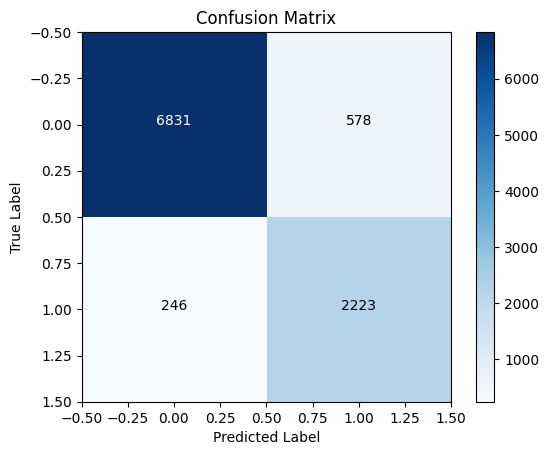

Accuracy: 0.9166
Precision: 0.7936
Recall: 0.9004
F1-Score: 0.8436


In [35]:
df_payment = seperate_on_type(df, 'PAYMENT')
df_payment = equal_width_binning(df_payment, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_payment, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_3 ? 0.17372320026078536
├─ Value = 0.0
│  X_1 ? 0.23496160586152648
│  ├─ Value = 1.0
│  │  0.0
│  ├─ Value = 2.0
│  │  0.0
│  ├─ Value = 3.0
│  │  X_0 ? 0.39669421487603307
│  │  ├─ Value = 333.0
│  │  │  1.0
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  ├─ Value = 888.0
│  │  │  0.0
│  │  └─ 
│  ├─ Value = 4.0
│  │  0.0
│  ├─ Value = 5.0
│  │  0.0
│  ├─ Value = 6.0
│  │  0.0
│  ├─ Value = 7.0
│  │  0.0
│  ├─ Value = 8.0
│  │  0.0
│  ├─ Value = 9.0
│  │  0.0
│  ├─ Value = 10.0
│  │  0.0
│  ├─ Value = 11.0
│  │  0.0
│  ├─ Value = 12.0
│  │  0.0
│  ├─ Value = 13.0
│  │  0.0
│  ├─ Value = 14.0
│  │  0.0
│  ├─ Value = 15.0
│  │  0.0
│  ├─ Value = 16.0
│  │  0.0
│  ├─ Value = 17.0
│  │  0.0
│  ├─ Value = 18.0
│  │  0.0
│  ├─ Value = 19.0
│  │  X_0 ? 0.19753086419753085
│  │  ├─ Value = 777.0
│  │  │  0.0
│  │  ├─ Value = 888.0
│  │  │  0.0
│  │  ├─ Value = 999.0
│  │  │  1.0
│  │  └─ 
│  ├─ Value = 21.0
│  │  0.0
│  ├─ Value = 22.0
│  │  0.0
│  ├─ Value = 24.0
│  │  0.0
│  ├─ Value = 25.0
│ 

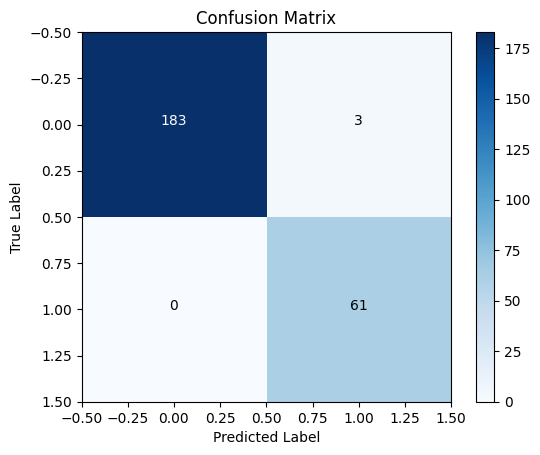

Accuracy: 0.9879
Precision: 0.9531
Recall: 1.0000
F1-Score: 0.9760


In [36]:
df_debit = seperate_on_type(df, 'DEBIT')
df_debit = equal_width_binning(df_debit, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_debit, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]

print_eval(y_pred, y_test)

#### Result
As seen, separating the data based on the transaction type and training individual models for each type significantly improves the results. For future use, a simple switch case can be employed based on the transaction type, and the suitable model can be selected accordingly.

### Skit-learn and XGBoost Models
In this part, models from popular machine learning libraries, such as `Scikit-learn` and `XGBoost`, are used with One Hot Encoding.

In [37]:
X_train, X_test, y_train, y_test = split_data(df_oneHot, test_size=0.25, pos_ratio=0.25)

#### Decision Tree -> Gini Index

[[18132   618]
 [ 1988  4262]]


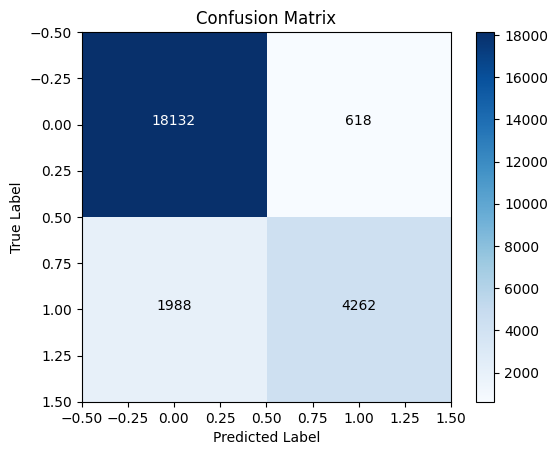

Accuracy: 0.8958
Precision: 0.8734
Recall: 0.6819
F1-Score: 0.7659


In [38]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
classifier_dt.fit(X_train, y_train)
y_pred = classifier_dt.predict(X_test)
print_eval(y_pred, y_test)

#### Decision Tree -> Entropy

[[18176   574]
 [ 1989  4261]]


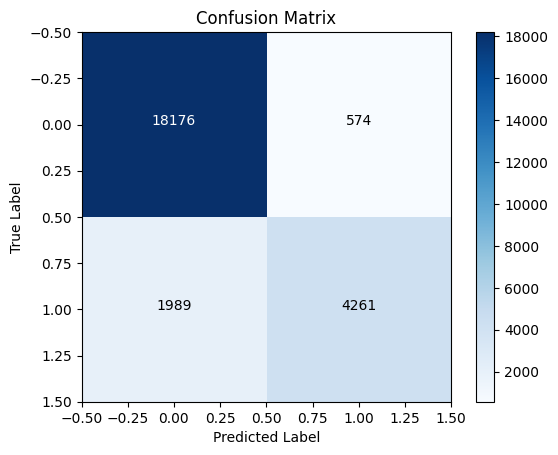

Accuracy: 0.8975
Precision: 0.8813
Recall: 0.6818
F1-Score: 0.7688


In [39]:
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
classifier_dt.fit(X_train, y_train)
y_pred = classifier_dt.predict(X_test)
print_eval(y_pred, y_test)

#### Logistic Regression

c:\Users\Arshia\Desktop\ArshiaGoshtasbi_DT_Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[18738    12]
 [ 6208    42]]


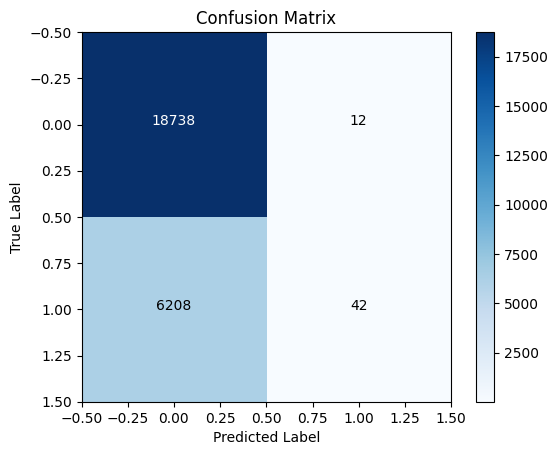

Accuracy: 0.7512
Precision: 0.7778
Recall: 0.0067
F1-Score: 0.0133


In [40]:
from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression(random_state = 42)
classifier_logistic.fit(X_train, y_train)
y_pred = classifier_logistic.predict(X_test)
print_eval(y_pred, y_test)

#### Random Forest

[[18738    12]
 [ 6208    42]]


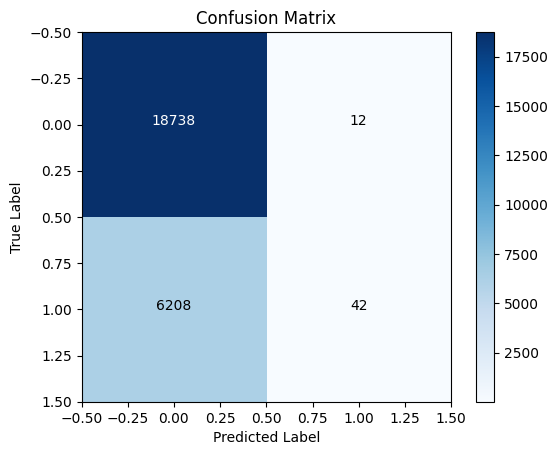

Accuracy: 0.7512
Precision: 0.7778
Recall: 0.0067
F1-Score: 0.0133


In [41]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier_rf.fit(X_train, y_train)
y_pred = classifier_logistic.predict(X_test)
print_eval(y_pred, y_test)

#### XGBoost

[[18550   200]
 [ 4173  2077]]


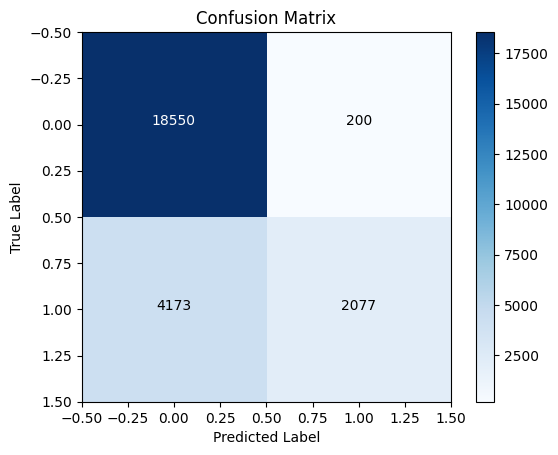

Accuracy: 0.8251
Precision: 0.9122
Recall: 0.3323
F1-Score: 0.4872


In [42]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)
y_pred = classifier_xgb.predict(X_test)
print_eval(y_pred, y_test)

#### Result
As seen, even powerful libraries like `Scikit-learn` and `XGBoost` cannot perform well without separating the dataset based on the transaction type.

## Conclusion
As this Jupyter Notebook demonstrates, in datasets where the overall positive cases are low, the best approach is to separate the dataset into sub-datasets and perform modeling on each subset individually. This technique leads to significantly improved results compared to treating the dataset as a whole.

Additionally, the notebook highlights the importance of preprocessing techniques, such as one-hot encoding and binning, in enhancing the performance of machine learning models. By carefully engineering features and handling categorical and continuous variables, the models can better capture the underlying patterns in the data.

Overall, this notebook provides a comprehensive exploration of decision tree algorithms for fraud detection in online transactions, emphasizing the importance of data preprocessing, feature engineering, and model evaluation. The insights gained from this analysis can be valuable for practitioners working in the field of fraud detection and risk management.